In [1]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from torch.nn.functional import mse_loss, l1_loss
from movqgan import get_movqgan_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/miniconda3/envs/lavit/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_images(batch, return_image=False):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    if return_image:
        return Image.fromarray(reshaped.numpy())
    display(Image.fromarray(reshaped.numpy()))


def prepare_image(img):
    """ Transform and normalize PIL Image to tensor. """
    transform = T.Compose([
            T.RandomResizedCrop(512, scale=(1., 1.), ratio=(1., 1.), interpolation=T.InterpolationMode.BICUBIC),
        ])
    pil_image = transform(img)
    arr = np.array(pil_image.convert("RGB"))
    arr = arr.astype(np.float32) / 127.5 - 1
    return torch.from_numpy(np.transpose(arr, [2, 0, 1]))

In [3]:
device = "mps"
model = get_movqgan_model('67M', pretrained=True, device=device)

img = prepare_image(Image.open("image.jpg")).to(device).unsqueeze(0)

Working with z of shape (1, 4, 32, 32) = 4096 dimensions.


MSE: 0.00427
L1: 0.03868


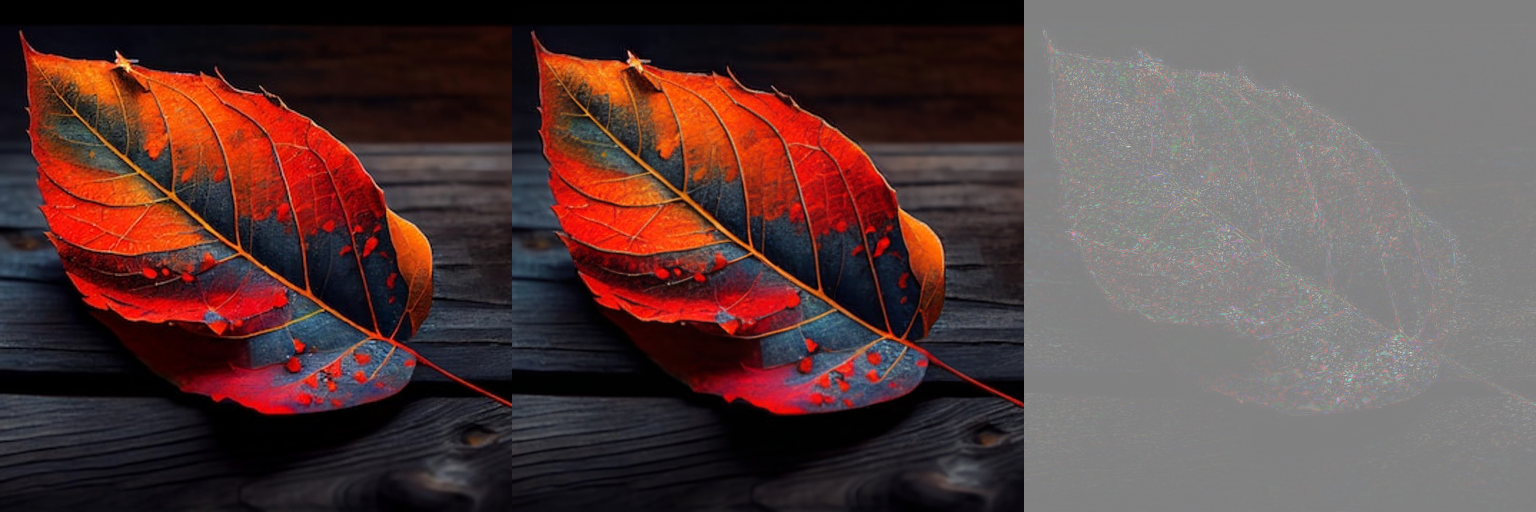

In [4]:
with torch.no_grad():
    # quant = embeddings(codebook_indices)
    quant, loss, (perplexity, min_encodings, codebook_indices) = model.encode(img)
    out = model.decode(quant)

mse = np.round(mse_loss(img, out).item(), 5)
l1 = np.round(l1_loss(img, out).item(), 5)

print("MSE:", mse)
print("L1:", l1)
show_images(torch.cat((img, out, torch.abs(img - out)), dim=0))

In [11]:
from sklearn.cluster import KMeans


embeddings = model.quantize.embedding.weight
embeddings = embeddings.detach().cpu().numpy()

k = 1000
rate = 0.2

def get_cluster_indices(clustering_object):
    clusters = {i: [] for i in range(clustering_object.n_clusters)}
    for idx, label in enumerate(clustering_object.labels_):
        clusters[label].append(idx)
    clusters = {k: torch.tensor(v, device=device) for k, v in clusters.items()}
    return clusters


kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(embeddings)
clusters = get_cluster_indices(kmeans)

0.781005859375


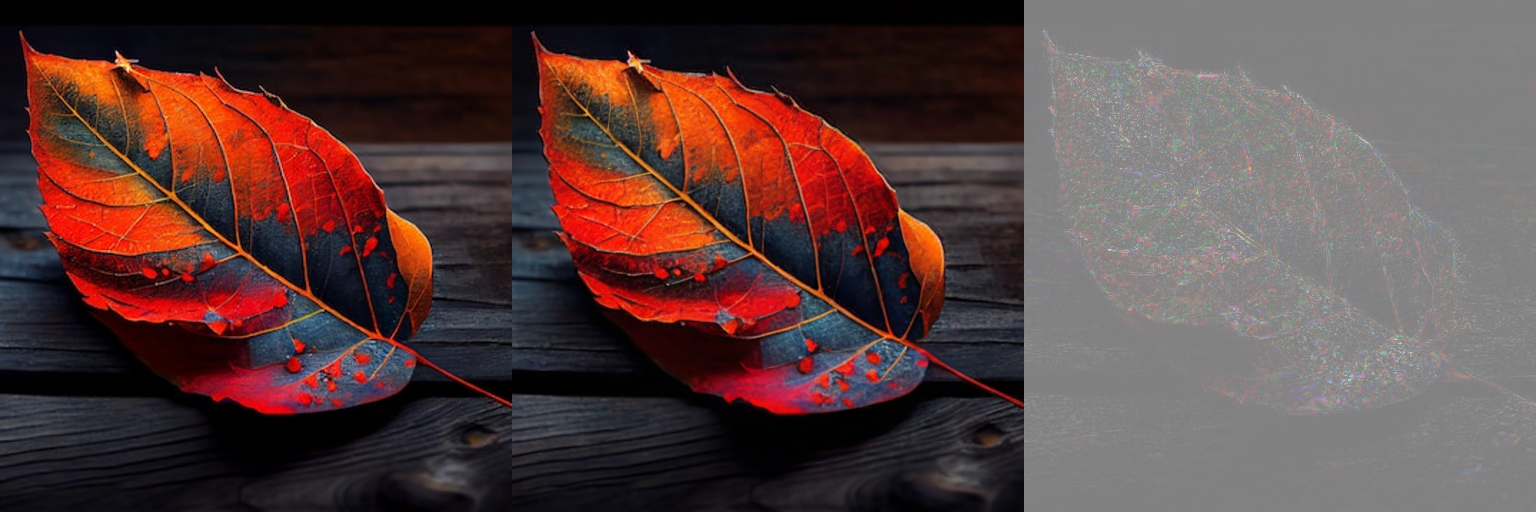

In [12]:
import watermarking


codes = codebook_indices

watermarked = watermarking.replace_codes_within_clusters(codes, clusters=clusters, rate=0.25)
print((watermarked == codes).cpu().numpy().mean())

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked.view(1, 64, 64))

show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))

mps:0 mps:0
0.07763671875
1010101010101010101010101010101010101010101010101010101010101000
[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


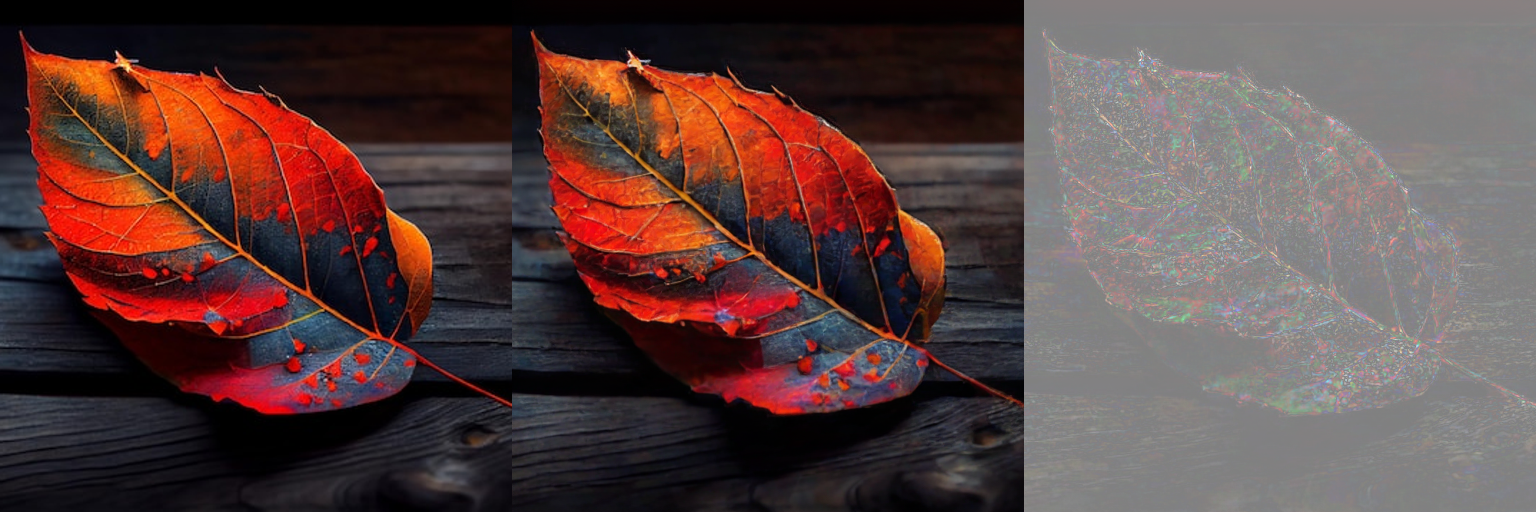

In [7]:
payload = 0b1010101010101010101010101010101010101010101010101010101010101000
watermarked = watermarking.redgreen_embed_payload(codes, clusters=clusters, payload=payload, n_payload_bits=64)
print((watermarked == codes).cpu().numpy().mean())

detection_info = watermarking.detect_payload(watermarked, clusters=clusters, n_payload_bits=64)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:064b}")
print(detection_info["average_bits"])

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked.view(1, 64, 64))

show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))

In [8]:
detection_info = watermarking.detect_payload(codes, clusters=clusters, n_payload_bits=64)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:064b}")
print(detection_info["average_bits"])

[0.0, 0.8888888955116272, 0.3333333432674408, 0.2857142984867096, 0.6000000238418579, 0.4000000059604645, 0.5, 0.75, 0.5833333134651184, 0.4000000059604645, 0.5, 0.4285714328289032, 0.0, 0.5, 0.3333333432674408, 0.3333333432674408, 0.5714285969734192, 0.5833333134651184, 0.4000000059604645, 0.20000000298023224, 0.2857142984867096, 0.20000000298023224, 0.4545454680919647, 0.5, 0.5, 0.5833333134651184, 0.2222222238779068, 0.6666666865348816, 0.5555555820465088, 0.5, 0.46666666865348816, 0.4545454680919647, 0.4545454680919647, 0.25, 0.4375, 0.5555555820465088, 0.3636363744735718, 0.3684210479259491, 0.30000001192092896, 0.3636363744735718, 0.3333333432674408, 0.6666666865348816, 0.5, 0.5555555820465088, 1.0, 0.5714285969734192, 0.5, 0.3333333432674408, 0.699999988079071, 0.27272728085517883, 0.3333333432674408, 0.5, 0.4615384638309479, 0.3333333432674408, 0.7777777910232544, 0.25, 0.875, 0.5833333134651184, 0.4444444477558136, 0.375, 0.6666666865348816, 0.4000000059604645, 0.5, 0.42857143

### Ablate clustering

#### K-means with other k

In [9]:
k = 5000

clustering_object = KMeans(n_clusters=k, random_state=42)
clustering_object.fit(embeddings)
clusters = get_cluster_indices(clustering_object)

watermarked = watermarking.redgreen_embed_payload(codes, clusters=clusters, payload=payload, n_payload_bits=64)

detection_info = watermarking.detect_payload(watermarked, clusters=clusters, n_payload_bits=64)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:064b}")
print(detection_info["average_bits"])

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked.view(1, 64, 64))

mse = np.round(mse_loss(img, watermarked_image).item(), 5)
l1 = np.round(l1_loss(img, watermarked_image).item(), 5)

print("MSE:", mse)
print("L1:", l1)

1010101010101010101010101010101010101010101010101010101010101000
[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
MSE: 0.00574
L1: 0.04846


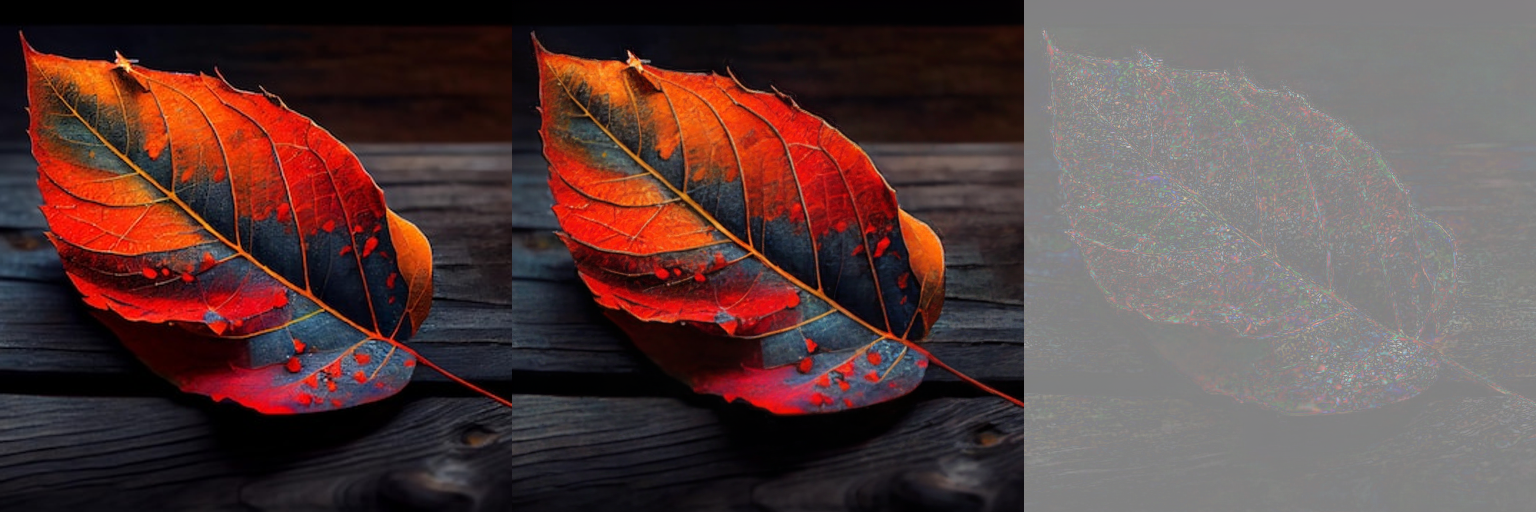

In [10]:
show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))

1000001010001010100010101000100010001000000010101010101010000000
[1.0, 0.0, nan, 0.0, nan, 0.0, 1.0, 0.0, 1.0, 0.0, nan, 0.0, 1.0, nan, 1.0, 0.0, 1.0, nan, nan, nan, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, nan, 0.0, 1.0, nan, nan, 0.0, 1.0, 0.0, nan, 0.0, 1.0, nan, nan, 0.0, nan, 0.0, nan, nan, 1.0, 0.0, 1.0, nan, 1.0, 0.0, 1.0, nan, 1.0, 0.0, 1.0, 0.0, 1.0, nan, nan, nan, nan, nan, nan, 0.0]
MSE: 0.00428
L1: 0.03918


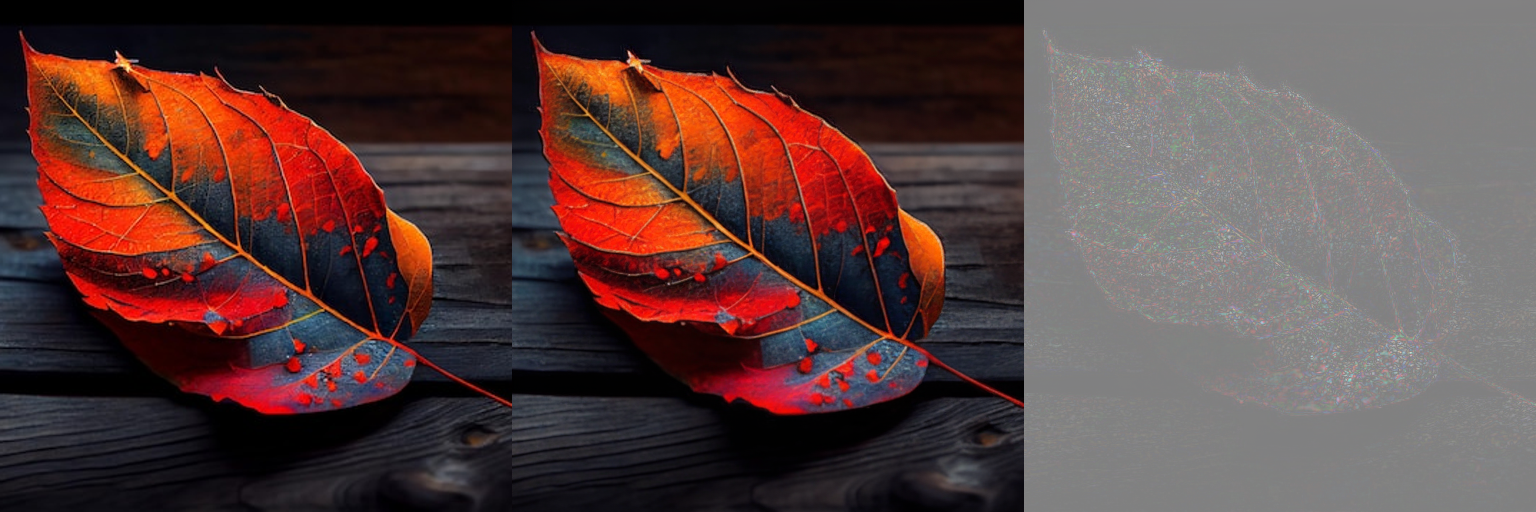

In [26]:
k = 8000

clustering_object = KMeans(n_clusters=k, random_state=42)
clustering_object.fit(embeddings)
clusters = get_cluster_indices(clustering_object)

watermarked = watermarking.redgreen_embed_payload(codes, clusters=clusters, payload=payload, n_payload_bits=64)

detection_info = watermarking.detect_payload(watermarked, clusters=clusters, n_payload_bits=64)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:064b}")
print(detection_info["average_bits"])

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked.view(1, 64, 64))

mse = np.round(mse_loss(img, watermarked_image).item(), 5)
l1 = np.round(l1_loss(img, watermarked_image).item(), 5)

print("MSE:", mse)
print("L1:", l1)
show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))

#### Other clustering algorithms

In [24]:
from sklearn.cluster import DBSCAN


eps = 1e-4
min_samples = 10


def get_cluster_indices(clustering_object):
    # Extract unique cluster labels, excluding noise (-1 label)
    unique_labels = set(clustering_object.labels_)
    unique_labels.discard(-1)  # Remove noise label
    
    clusters = {label: [] for label in unique_labels}
    for idx, label in enumerate(clustering_object.labels_):
        if label != -1:  # Ignore noise points
            clusters[label].append(idx)
    clusters = {k: torch.tensor(v, device=device) for k, v in clusters.items()}
    return clusters


clustering_object = DBSCAN(eps=eps, min_samples=min_samples)
clustering_object.fit(embeddings)
clusters = get_cluster_indices(clustering_object)

print(clusters.keys())

dict_keys([np.int64(0)])


In [ ]:
watermarked = watermarking.redgreen_embed_payload(codes, clusters=clusters, payload=payload, n_payload_bits=64)

detection_info = watermarking.detect_payload(watermarked, clusters=clusters, n_payload_bits=64)
if detection_info["watermarked"]:
    print(f"{detection_info['payload']:064b}")
print(detection_info["average_bits"])

with torch.no_grad():
    watermarked_image = model.decode_code(watermarked.view(1, 64, 64))

mse = np.round(mse_loss(img, watermarked_image).item(), 5)
l1 = np.round(l1_loss(img, watermarked_image).item(), 5)

print("MSE:", mse)
print("L1:", l1)
show_images(torch.cat((img, watermarked_image, torch.abs(img - watermarked_image)), dim=0))